In [1]:
%load_ext autoreload
%autoreload 2

from statsmodels.tsa.stattools import adfuller 
from sklearn.linear_model import LinearRegression
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx #bibliothèque pour créer des graphs (réseaux)
import yfinance as yf
import pickle #pour la sérialisation du dictionnaire
from datetime import datetime
import class_backtest as cb
import methodes as mt

# Scrapping

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selectolax.parser import HTMLParser
import pandas as pd

headless = False 

options = webdriver.ChromeOptions()
if headless==True : 
    options.add_argument('--headless')  # Mode sans interface
options.add_argument('--no-sandbox')
options.add_argument('--disable-dev-shm-usage')
    
driver = webdriver.Chrome(options=options)
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
driver.get(url) #on ouvre la page 

tree = HTMLParser(driver.page_source)

array = tree.css_first("table.wikitable.sortable")
headers = array.css("thead > tr > th")
lines = array.css("tbody > tr")

#creation of the dataframe 
df_snp = pd.DataFrame(columns=[el.text().strip() for el in headers])
for line in lines : 
    tds = line.css("td")
    df_snp.loc[len(df_snp)] = [el.text().strip() for el in tds] 
driver.close()

## Backtesting de la stratégie

Chargement des données

In [6]:
backtest = cb.BackTest(df_snp)

df_trades_month, df_wallet_periode = backtest.main("2025-01-01", "2026-01-01", 150000, interet_compose=False, fee=True)

c:\Users\lance\OneDrive - De Vinci\Documents\A3\PERSO\PAIR TRADING\PROJET\NEW\class_backtest.py:338: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.df = yf.download(list(self.tickers), start=self.date_debut_data, end=self.date_fin_trading)
[*********************100%***********************]  78 of 78 completed
c:\Users\lance\OneDrive - De Vinci\Documents\A3\PERSO\PAIR TRADING\PROJET\NEW\class_backtest.py:338: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.df = yf.download(list(self.tickers), start=self.date_debut_data, end=self.date_fin_trading)
[*********************100%***********************]  60 of 60 completed
c:\Users\lance\OneDrive - De Vinci\Documents\A3\PERSO\PAIR TRADING\PROJET\NEW\class_backtest.py:338: FutureWarning: YF.download() has changed argument auto_adjust default to True
  self.df = yf.download(list(self.tickers), start=self.date_debut_data, end=self.date_fin_trading)
[*********************10

sauvegarde des données

In [7]:
with open(r"Methode_ranking2\2eEssai_NonCompose\2025_trades.pkl", 'wb') as f:  # 'wb' = write binary
        pickle.dump(df_trades_month, f)
        
with open(r"Methode_ranking2\2eEssai_NonCompose\2025_wallet.pkl", 'wb') as f:  # 'wb' = write binary
        pickle.dump(df_wallet_periode, f)

Comparaison entre interet composé et interet classique

0.3494646197661835


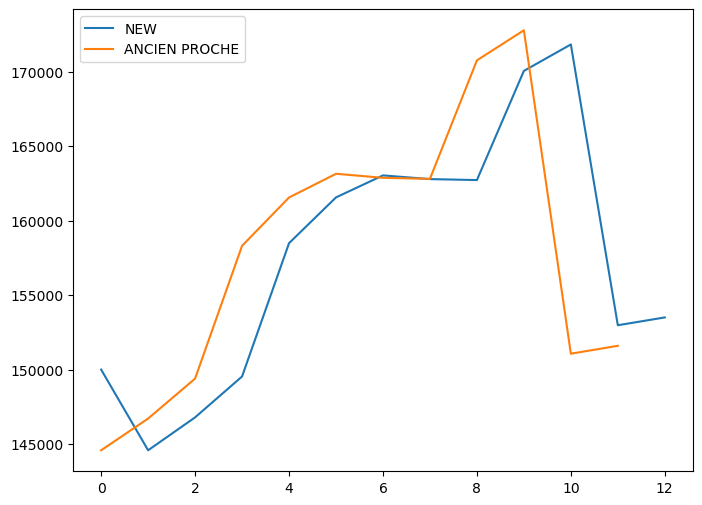

In [ ]:
plt.figure(figsize=(8,6))

with open(r"Methode_ranking2\2eEssai_NonCompose\2025_wallet.pkl", 'rb') as f:
    wallet = pickle.load(f)
value_month = wallet["value"]-150000
value_month = pd.concat([pd.Series([150000]), value_month]).reset_index(drop=True)
plt.plot(value_month.cumsum(), label="NEW")

with open(r"Methode_ranking2\2eEssai\2025_wallet.pkl", 'rb') as f:
    wallet = pickle.load(f)

plt.plot(wallet["value"], label="ANCIEN PROCHE")
print((df_wallet_periode["value"].iloc[-1]-150000)*100/150000)
plt.legend()
plt.show()

# AnalyseGlobal

## Analyse des performances Compose

In [14]:
#Fonctions 
def sharpe_ann(serie_valeurs) :     
    rf_annual = 3.6/100
    ret = serie_valeurs.pct_change().dropna()
    rf_monthly = (1 + rf_annual)**(1/12) - 1 
    excess_ret = ret - rf_monthly 
    sharpe_montly = excess_ret.mean() / excess_ret.std(ddof=1)

    sharpe_annualise = sharpe_montly * np.sqrt(12)
    return sharpe_annualise

def get_max_drawdown(serie_valeurs) : 
    rolling_max = serie_valeurs.cummax()
    drawdown = (serie_valeurs - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    return max_drawdown

In [39]:
chemin_dossier = lambda date : rf"Methode_ranking2\2eEssai\{date}_wallet.pkl"

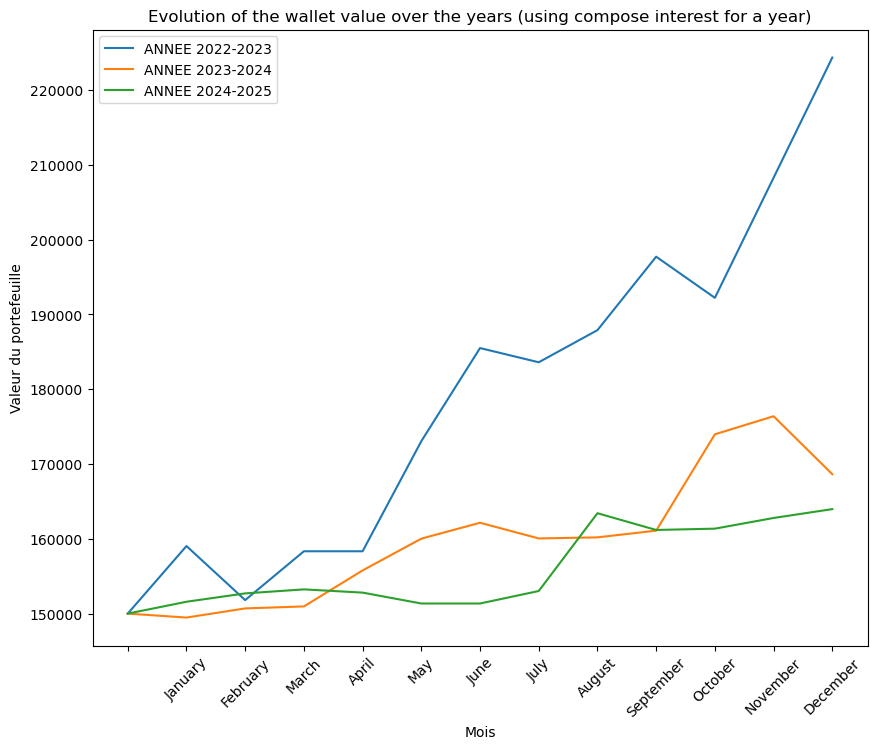

In [40]:
dates = [i for i in range(2022,2026)]
mois = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.figure(figsize=(10, 8))
for id_date in range(len(dates)-1): 
    with open(chemin_dossier(dates[id_date]), 'rb') as f:
        wallet = pickle.load(f)
    new_row = {'date_debut' : f"{dates[id_date]}-01-01", "date_fin" : f'{dates[id_date]}-01-01', 'value' : 150000}
    wallet = pd.concat([pd.DataFrame([new_row]), wallet]).reset_index(drop=True)

    plt.plot(([""] + mois),  wallet["value"], label=f"ANNEE {dates[id_date]}-{dates[id_date+1]}")

plt.xlabel("Mois")
plt.ylabel("Valeur du portefeuille")
plt.xticks(rotation=45)
plt.title("Evolution of the wallet value over the years (using compose interest for a year)")
plt.legend()
plt.show()

In [41]:
#Tableau des différents indicateurs
dates = [i for i in range(2022,2026)]

indicateurs = pd.DataFrame(columns=["Year", "Final Value", "Profitability (%)", "Max Drawdown (%)", "Volatility (%)", "Annual Sharpe Ratio"])

for id_date in range(len(dates)-1): 
    with open(chemin_dossier(dates[id_date]), 'rb') as f:
        wallet = pickle.load(f)
    new_row = {'date_debut' : f"{dates[id_date]}-01-01", "date_fin" : f'{dates[id_date]}-01-01', 'value' : 150000}
    wallet = pd.concat([pd.DataFrame([new_row]), wallet]).reset_index(drop=True)

    dictionnaire_res = {"Year" : f"{dates[id_date]}-{dates[id_date+1]}", "Final Value" : wallet["value"].iloc[-1]}
    
    profitability = (wallet["value"].iloc[-1]-150000)*100/150000
    dictionnaire_res["Profitability (%)"] = round(profitability, 2)

    max_drawdown = get_max_drawdown(wallet["value"])*100
    dictionnaire_res["Max Drawdown (%)"] = round(max_drawdown, 2)

    volatility = wallet["value"].pct_change().std(ddof=1)*100
    dictionnaire_res["Volatility (%)"] = round(volatility, 2)

    sharpe_ratio = sharpe_ann(wallet["value"])
    dictionnaire_res["Annual Sharpe Ratio"] = round(sharpe_ratio, 2)
    indicateurs = pd.concat([indicateurs, pd.DataFrame([dictionnaire_res])], ignore_index=True)
indicateurs

#ligne global 
dict_global = {
    "Year" : "GLOBAL", 
    "Final Value" : indicateurs["Final Value"].mean(), 
    "Profitability (%)" : indicateurs["Profitability (%)"].mean(), 
    "Max Drawdown (%)" : indicateurs["Max Drawdown (%)"].mean(), 
    "Volatility (%)" : indicateurs["Volatility (%)"].mean(), 
    "Annual Sharpe Ratio" : indicateurs["Annual Sharpe Ratio"].mean()
}
indicateurs = pd.concat([indicateurs, pd.DataFrame([dict_global])], ignore_index=True)
indicateurs


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32688\811509780.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  indicateurs = pd.concat([indicateurs, pd.DataFrame([dictionnaire_res])], ignore_index=True)


,Year,Final Value,Profitability (%),Max Drawdown (%),Volatility (%),Annual Sharpe Ratio
0,2022-2023,224330.100417,49.55,-4.540000,4.64,2.400000
1,2023-2024,168629.891676,12.42,-4.390000,2.94,0.850000
2,2024-2025,163965.511488,9.31,-1.370000,2.05,0.790000
3,GLOBAL,185641.834527,23.76,-3.433333,3.21,1.346667


Répartition des variations mensuelles

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32688\66274234.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  variations_mensuelles = pd.concat([variations_mensuelles, monthly_returns], ignore_index=True)


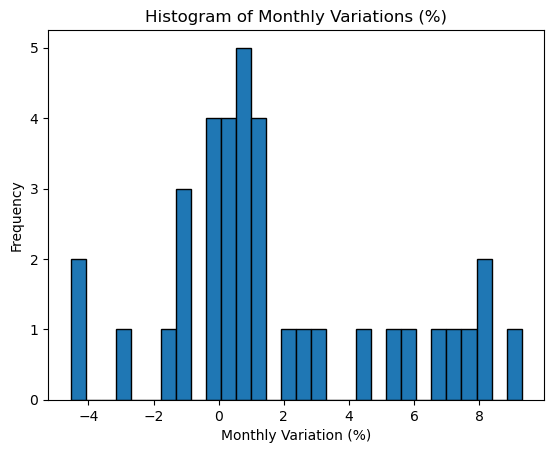

Percentage of positive variations: 75.00%
Percentage of negative variations: 25.00%
Average monthly variation: 1.76%


In [35]:
#Tableau des différents indicateurs
dates = [i for i in range(2022,2026)]

variations_mensuelles = pd.Series()

for id_date in range(len(dates)-1): 
    # Chargement du wallet
    with open(chemin_dossier(dates[id_date]), 'rb') as f:
        wallet = pickle.load(f)

    # Ajouter une première ligne pour le calcul de pct_change
    new_row = {'date_debut': f"{dates[id_date]}-01-01",
               'date_fin': f"{dates[id_date]}-01-01",
               'value': 150000}
    wallet = pd.concat([pd.DataFrame([new_row]), wallet]).reset_index(drop=True)

    # Calcul des variations mensuelles
    monthly_returns = wallet["value"].pct_change().dropna().reset_index(drop=True) * 100
    variations_mensuelles = pd.concat([variations_mensuelles, monthly_returns], ignore_index=True)

plt.hist(variations_mensuelles, bins=30, edgecolor='black')
plt.title("Histogram of Monthly Variations (%)")
plt.xlabel("Monthly Variation (%)")
plt.ylabel("Frequency")
plt.show()

nb_positif = len(variations_mensuelles[variations_mensuelles >= 0])
print(f"Percentage of positive variations: {nb_positif*100/len(variations_mensuelles):.2f}%")
print(f"Percentage of negative variations: {(len(variations_mensuelles)-nb_positif)*100/len(variations_mensuelles):.2f}%")
print(f"Average monthly variation: {variations_mensuelles.mean():.2f}%")

beta de la stratégie par rapport au SnP

In [110]:
#On récupere toutes les données du snp sur la période
snp_values = yf.download("^GSPC", start="2022-01-01", end="2025-01-01")
snp_values = snp_values["Close"]

#Pour le snp_values on récupere la premiere valeur pour chaque mois 
snp_value_month = pd.Series()
snp_values["Month"] = snp_values.index.to_period("M")
all_month = snp_values["Month"].value_counts().index.sort_values().tolist()
for month in all_month : 
    first_date = snp_values[snp_values["Month"]==month].index.min()
    snp_value_month.loc[f"{month}-01"] = snp_values.loc[first_date, "^GSPC"]

variations_snp = snp_value_month.pct_change().dropna()*100

dates = [i for i in range(2022,2026)]

value_tot = pd.DataFrame()

for id_date in range(len(dates)-1): 
    # Chargement du wallet
    with open(chemin_dossier(dates[id_date]), 'rb') as f:
        wallet = pickle.load(f)
    value_tot = pd.concat([value_tot, wallet[["date_debut", "value"]]], ignore_index=True)
variation_moi = value_tot["value"].pct_change().dropna()*100

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32688\3357059761.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  snp_values = yf.download("^GSPC", start="2022-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


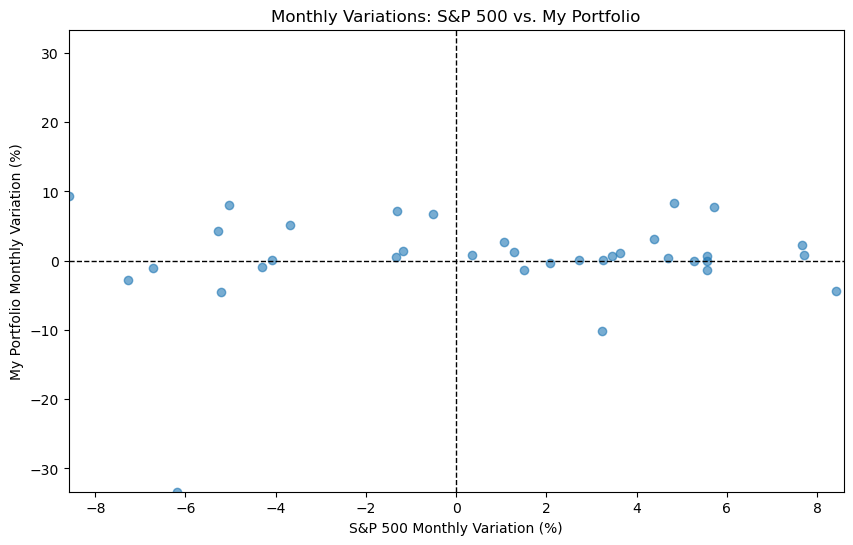

Béta de mon portefeuille par rapport au S&P 500 : 0.0049


In [119]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(variations_mensuelles, variation_moi, alpha=0.6)
plt.title("Monthly Variations: S&P 500 vs. My Portfolio")
plt.xlabel("S&P 500 Monthly Variation (%)")
plt.ylabel("My Portfolio Monthly Variation (%)")

# Centrer l'axe Y autour de zéro
max_val = max(abs(variation_moi.max()), abs(variation_moi.min()))
plt.ylim(-max_val, max_val)

# Optionnel : centrer l'axe X aussi si tu veux un plot symétrique
max_val_x = max(abs(variations_mensuelles.max()), abs(variations_mensuelles.min()))
plt.xlim(-max_val_x, max_val_x)

plt.axhline(0, color='black', linewidth=1, linestyle='--')  # ligne horizontale y=0
plt.axvline(0, color='black', linewidth=1, linestyle='--')  # ligne verticale x=0

plt.show()

#Analyse du béta 
correlation = np.corrcoef(variation_moi, variations_snp)[0,1]
variance_snp = variations_snp.var()
beta = correlation / variance_snp
print(f"Béta de mon portefeuille par rapport au S&P 500 : {beta:.4f}")

## Analyse des performances NON COMPOSE

In [24]:
chemin_dossier = lambda date : rf"Methode_ranking2\2eEssai_NonCompose\{date}_wallet.pkl"

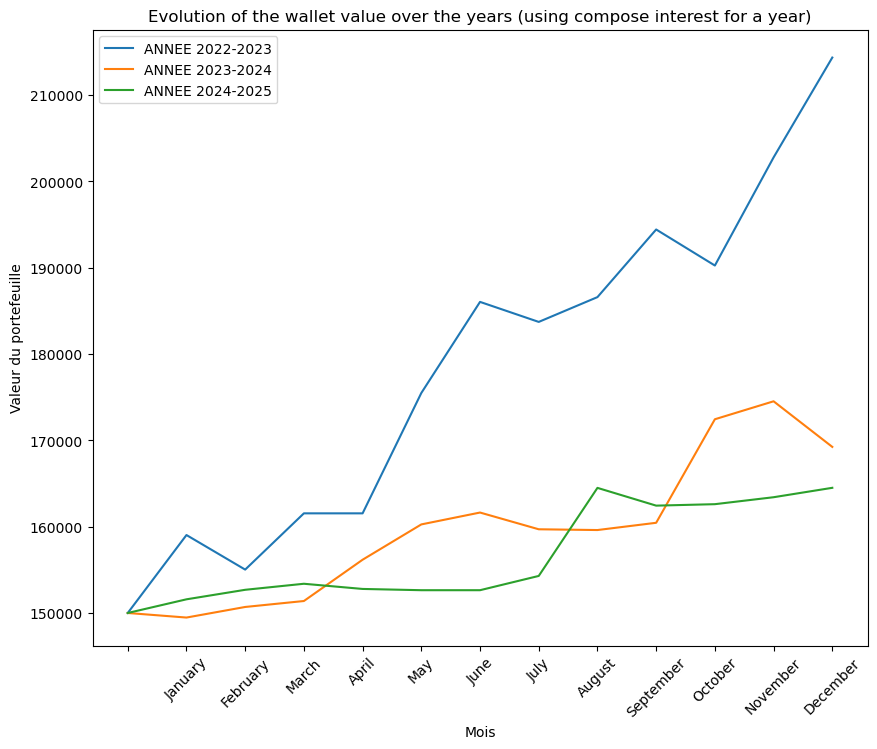

In [25]:
dates = [i for i in range(2022,2026)]
mois = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
plt.figure(figsize=(10, 8))
for id_date in range(len(dates)-1): 
    with open(chemin_dossier(dates[id_date]), 'rb') as f:
        wallet = pickle.load(f)
    wallet["value"] = wallet["value"] - 150000 

    new_row = {'date_debut' : f"{dates[id_date]}-01-01", "date_fin" : f'{dates[id_date]}-01-01', 'value' : 150000}
    wallet = pd.concat([pd.DataFrame([new_row]), wallet]).reset_index(drop=True)

    wallet_affichage = wallet["value"].cumsum()
    plt.plot(([""] + mois),  wallet_affichage, label=f"ANNEE {dates[id_date]}-{dates[id_date+1]}")

plt.xlabel("Mois")
plt.ylabel("Valeur du portefeuille")
plt.xticks(rotation=45)
plt.title("Evolution of the wallet value over the years (using compose interest for a year)")
plt.legend()
plt.show()

In [26]:
#Tableau des différents indicateurs
dates = [i for i in range(2022,2026)]

indicateurs = pd.DataFrame(columns=["Year", "Final Value", "Profitability (%)", "Max Drawdown (%)", "Volatility (%)", "Annual Sharpe Ratio"])

for id_date in range(len(dates)-1): 
    with open(chemin_dossier(dates[id_date]), 'rb') as f:
        wallet = pickle.load(f)
    
    wallet["value"] = wallet["value"] - 150000 
    new_row = {'date_debut' : f"{dates[id_date]}-01-01", "date_fin" : f'{dates[id_date]}-01-01', 'value' : 150000}
    wallet = pd.concat([pd.DataFrame([new_row]), wallet]).reset_index(drop=True)
    wallet["value"] = wallet["value"].cumsum()
    dictionnaire_res = {"Year" : f"{dates[id_date]}-{dates[id_date+1]}", "Final Value" : wallet["value"].iloc[-1]}
    
    profitability = (wallet["value"].iloc[-1]-150000)*100/150000
    dictionnaire_res["Profitability (%)"] = round(profitability, 2)

    max_drawdown = get_max_drawdown(wallet["value"])*100
    dictionnaire_res["Max Drawdown (%)"] = round(max_drawdown, 2)

    volatility = wallet["value"].pct_change().std(ddof=1)*100
    dictionnaire_res["Volatility (%)"] = round(volatility, 2)

    sharpe_ratio = sharpe_ann(wallet["value"])
    dictionnaire_res["Annual Sharpe Ratio"] = round(sharpe_ratio, 2)
    indicateurs = pd.concat([indicateurs, pd.DataFrame([dictionnaire_res])], ignore_index=True)
indicateurs

#ligne global 
dict_global = {
    "Year" : "GLOBAL", 
    "Final Value" : indicateurs["Final Value"].mean(), 
    "Profitability (%)" : indicateurs["Profitability (%)"].mean(), 
    "Max Drawdown (%)" : indicateurs["Max Drawdown (%)"].mean(), 
    "Volatility (%)" : indicateurs["Volatility (%)"].mean(), 
    "Annual Sharpe Ratio" : indicateurs["Annual Sharpe Ratio"].mean()
}
indicateurs = pd.concat([indicateurs, pd.DataFrame([dict_global])], ignore_index=True)
indicateurs


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32688\170657092.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  indicateurs = pd.concat([indicateurs, pd.DataFrame([dictionnaire_res])], ignore_index=True)


,Year,Final Value,Profitability (%),Max Drawdown (%),Volatility (%),Annual Sharpe Ratio
0,2022-2023,214340.172437,42.890000,-2.520000,3.80,2.540000
1,2023-2024,169239.445772,12.830000,-3.030000,2.59,1.000000
2,2024-2025,164499.518945,9.670000,-1.250000,1.95,0.880000
3,GLOBAL,182693.045718,21.796667,-2.266667,2.78,1.473333


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_32688\4208519114.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  variations_mensuelles = pd.concat([variations_mensuelles, monthly_returns], ignore_index=True)


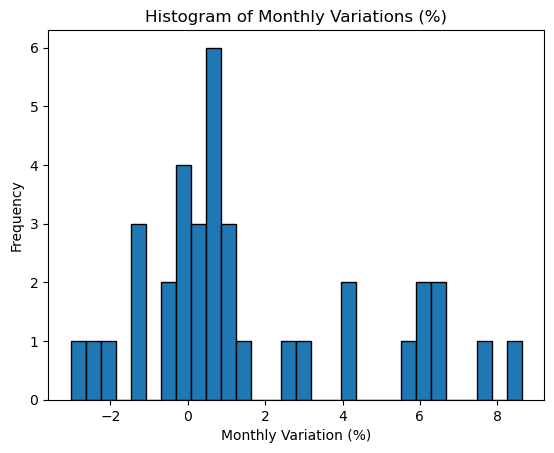

Percentage of positive variations: 72.22%
Percentage of negative variations: 27.78%
Average monthly variation: 1.64%


In [30]:
#Tableau des différents indicateurs
dates = [i for i in range(2022,2026)]

variations_mensuelles = pd.Series()

for id_date in range(len(dates)-1): 
    # Chargement du wallet
    with open(chemin_dossier(dates[id_date]), 'rb') as f:
        wallet = pickle.load(f)
    wallet["value"] = wallet["value"] - 150000
    # Ajouter une première ligne pour le calcul de pct_change
    new_row = {'date_debut': f"{dates[id_date]}-01-01",
               'date_fin': f"{dates[id_date]}-01-01",
               'value': 150000}
    wallet = pd.concat([pd.DataFrame([new_row]), wallet]).reset_index(drop=True)
    wallet["value"] = wallet["value"].cumsum()

    # Calcul des variations mensuelles
    monthly_returns = wallet["value"].pct_change().dropna().reset_index(drop=True) * 100
    variations_mensuelles = pd.concat([variations_mensuelles, monthly_returns], ignore_index=True)

plt.hist(variations_mensuelles, bins=30, edgecolor='black')
plt.title("Histogram of Monthly Variations (%)")
plt.xlabel("Monthly Variation (%)")
plt.ylabel("Frequency")
plt.show()

nb_positif = len(variations_mensuelles[variations_mensuelles >= 0])
print(f"Percentage of positive variations: {nb_positif*100/len(variations_mensuelles):.2f}%")
print(f"Percentage of negative variations: {(len(variations_mensuelles)-nb_positif)*100/len(variations_mensuelles):.2f}%")
print(f"Average monthly variation: {variations_mensuelles.mean():.2f}%")